<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [DDPM1] - Fashion MNIST Generation with DDPM
<!-- DESC --> Diffusion Model example, to generate Fashion MNIST images.

<!-- AUTHOR : Hatim Bourfoune (CNRS/IDRIS), Maxime Song (CNRS/IDRIS) -->

## Objectives :
 - Understanding and implementing a **Diffusion Model** neurals network (DDPM)

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale (need to adapt the code !) if you haven't a GPU ;-)


## Acknowledgements :
This notebook was heavily inspired by this [article](https://huggingface.co/blog/annotated-diffusion) and this [notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=5153024b).

In [ ]:
! pip install einops

In [ ]:
import math
from inspect import isfunction
from functools import partial
import random
import IPython

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
import numpy as np
import torch
from torch import nn, einsum
import torch.nn.functional as F
#from datasets import load_dataset, load_from_disk

from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from PIL import Image
from torch.optim import Adam

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Reproductibility
torch.manual_seed(53)
random.seed(53)
np.random.seed(53)

## Create dataset
We will use the library HuggingFace Datasets to get our Fashion MNIST. If you are using Jean Zay, the dataset is already downloaded in the DSDIR, so you can use the code as it is. If you are not using Jean Zay, you should use the function load_dataset (commented) instead of load_from_disk. It will automatically download the dataset if it is not downloaded already.

In [ ]:
#dataset = load_dataset("fashion_mnist")
#dataset
from torchvision import transforms, datasets
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)


As you can see the dataset is composed of two subparts: train and test. So the dataset is already split for us. We'll use the train part for now. <br/>
We can also see that the dataset as two features per sample: 'image' corresponding to the PIL version of the image and 'label' corresponding to the class of the image (shoe, shirt...). We can also see that there are 60 000 samples in our train dataset.

Each sample of a HuggingFace dataset is a dictionary containing the data.

In [ ]:
image = train_dataset[0][0].numpy()
channels, image_size1,image_size2 = image.shape
image_size=(image_size1,image_size2)
print(image_size)

(28, 28)


In [ ]:
image_array = np.asarray(image, dtype=np.uint8)
print(f"shape of the image: {image_array.shape}")
print(f"min: {image_array.min()}, max: {image_array.max()}")

shape of the image: (1, 28, 28)
min: 0, max: 255


We choose the parameters and we instantiate the dataset:

In [ ]:
# Dataset parameters
batch_size = 64
#data_path = "/gpfsdswork/dataset/HuggingFace/fashion_mnist/fashion_mnist/"
# data_path = "fashion_mnist"  # If you're not using Jean Zay

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=3)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=3)



batch_image = next(iter(train_dataloader))[0]
batch_image.shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 1, 28, 28])

We also create a function that allows us to see a batch of images:

In [ ]:
def normalize_im(images):
    shape = images.shape
    images = images.view(shape[0], -1)
    images -= images.min(1, keepdim=True)[0]
    images /= images.max(1, keepdim=True)[0]
    return images.view(shape)

def show_images(batch):
    plt.imshow(torch.permute(make_grid(normalize_im(batch)), (1,2,0)))
    plt.show()

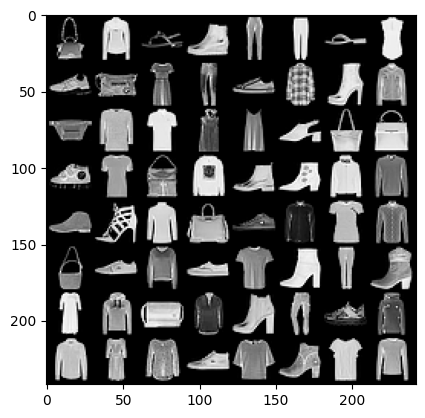

In [ ]:
show_images(batch_image[:])

## Forward Diffusion
The aim of this part is to create a function that will add noise to any image at any step (following the DDPM diffusion process).

### Beta scheduling
First, we create a function that will compute every betas of every steps (following a specific shedule). We will only create a function for the linear schedule (original DDPM) and the cosine schedule (improved DDPM):

In [ ]:
# Different type of beta schedule
def linear_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    """
    linar schedule from the original DDPM paper https://arxiv.org/abs/2006.11239
    """
    return torch.linspace(beta_start, beta_end, timesteps)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


### Constants calculation
We will now create a function to calculate every constants we need for our Diffusion Model. <br/>
Constants:
- $ \beta_t $: betas
- $ \sqrt{\frac{1}{\alpha_t}} $: sqrt_recip_alphas
- $ \sqrt{\bar{\alpha}_t} $: sqrt_alphas_cumprod
- $ \sqrt{1-\bar{\alpha}_t} $: sqrt_one_minus_alphas_cumprod
- $ \tilde{\beta}_t = \beta_t\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} $: posterior_variance

In [ ]:
# Function to get alphas and betas
def get_alph_bet(timesteps, schedule=cosine_beta_schedule):

    # define beta
    betas = schedule(timesteps)

    # define alphas
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0) # cumulative product of alpha
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # corresponding to the prev const
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    const_dict = {
        'betas': betas,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'posterior_variance': posterior_variance
    }

    return const_dict

### Difference between Linear and Cosine schedule
We can check the differences between the constants when we change the parameters:

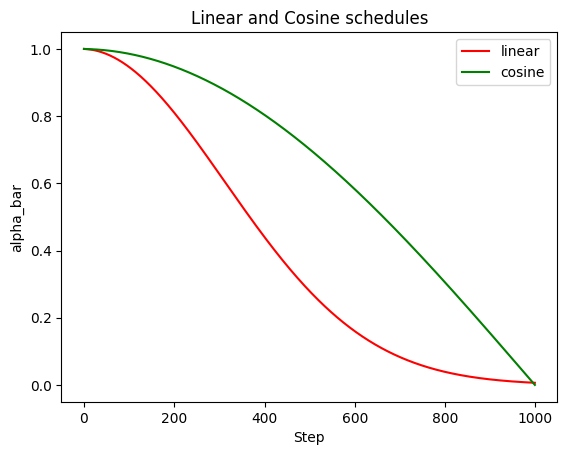

In [ ]:
T = 1000
const_linear_dict = get_alph_bet(T, schedule=linear_beta_schedule)
const_cosine_dict = get_alph_bet(T, schedule=cosine_beta_schedule)

plt.plot(np.arange(T), const_linear_dict['sqrt_alphas_cumprod'], color='r', label='linear')
plt.plot(np.arange(T), const_cosine_dict['sqrt_alphas_cumprod'], color='g', label='cosine')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Step")
plt.ylabel("alpha_bar")
plt.title("Linear and Cosine schedules")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

### Definition of $ q(x_t|x_0) $

In [ ]:
# extract the values needed for time t
def extract(constants, batch_t, x_shape):
    diffusion_batch_size = batch_t.shape[0]

    # get a list of the appropriate constants of each timesteps
    out = constants.gather(-1, batch_t.cpu())

    return out.reshape(diffusion_batch_size, *((1,) * (len(x_shape) - 1))).to(batch_t.device)


Now that we have every constants that we need, we can create a function that will add noise to an image following the forward diffusion process. This function (q_sample) corresponds to $ q(x_t|x_0) $:

![q_sample](https://docs.google.com/drawings/d/e/2PACX-1vQJ55FfJZ8FehNhnIEEeWUDaOAZqK5BuaadB9Xacx2bA222nNApwMHYzhgILaUrze_pTlc974BELJ2D/pub?w=3210&h=651)

In [ ]:
# forward diffusion (using the nice property)
def q_sample(constants_dict, batch_x0, batch_t, noise=None):
    if noise is None:
        noise = torch.randn_like(batch_x0)

    sqrt_alphas_cumprod_t = extract(constants_dict['sqrt_alphas_cumprod'], batch_t, batch_x0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_x0.shape
    )

    return sqrt_alphas_cumprod_t * batch_x0 + sqrt_one_minus_alphas_cumprod_t * noise

We can now visualize how the forward diffusion process adds noise gradually the image according to its parameters:

timesteps: tensor([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
        210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390, 405,
        420, 435, 450, 465, 480, 495, 510, 525, 540, 555, 570, 585, 600, 615,
        630, 645, 660, 675, 690, 705, 720, 735, 750, 765, 780, 795, 810, 825,
        840, 855, 870, 885, 900, 915, 930, 945])
Original images:


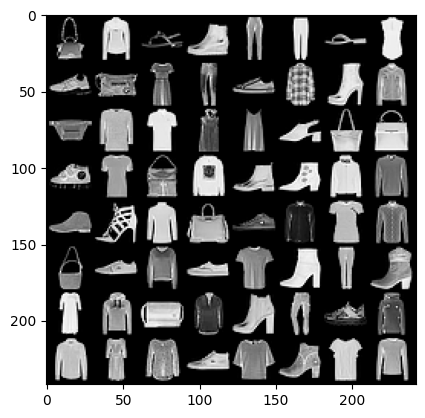

Noised images with linear shedule:


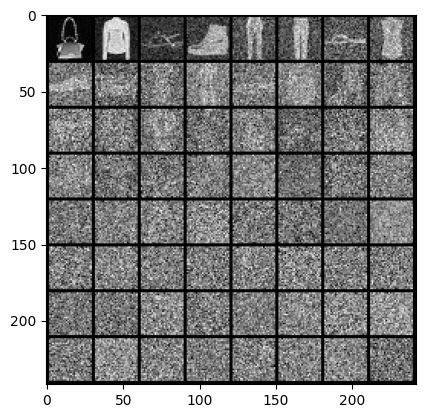

Noised images with cosine shedule:


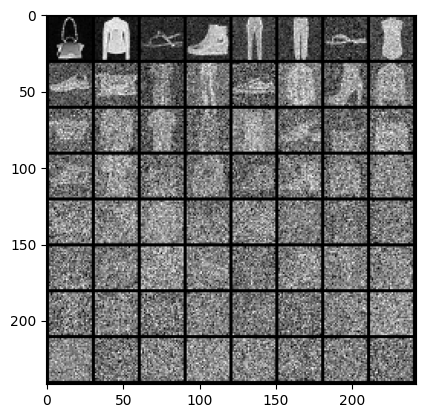

In [ ]:
T = 1000
const_linear_dict = get_alph_bet(T, schedule=linear_beta_schedule)
const_cosine_dict = get_alph_bet(T, schedule=cosine_beta_schedule)

batch_t = torch.arange(batch_size)*(T//batch_size)  # get a range of timesteps from 0 to T
print(f"timesteps: {batch_t}")
noisy_batch_linear = q_sample(const_linear_dict, batch_image, batch_t, noise=None)
noisy_batch_cosine = q_sample(const_cosine_dict, batch_image, batch_t, noise=None)

print("Original images:")
show_images(batch_image[:])

print("Noised images with linear shedule:")
show_images(noisy_batch_linear[:])

print("Noised images with cosine shedule:")
show_images(noisy_batch_cosine[:])

## Reverse Diffusion Process

### Model definition
The reverse diffusion process is made by a deep learning model. We choosed a Unet model with attention. The model is optimized following some papers like [ConvNeXt](https://arxiv.org/pdf/2201.03545.pdf). You can inspect the model in the model.py file.

In [ ]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial
import math
from einops import rearrange


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)


def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ConvNextBlock, mult=convnext_mult)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)


In [ ]:


model = Unet(
    dim=28,
    init_dim=None,
    out_dim=None,
    dim_mults=(1, 2, 4),
    channels=1,
    with_time_emb=True,
    convnext_mult=2,
)

### Definition of $ p_{\theta}(x_{t-1}|x_t) $
Now we need a function to retrieve $x_{t-1}$ from $x_t$ and the predicted $z_t$. It corresponds to the reverse diffusion kernel:
![p_sample](https://docs.google.com/drawings/d/e/2PACX-1vRogMTbBI_MtUz2WvFRKef0IKSNaKuFe475llm8nARBbvVCxezq4L00wJV7HjJSLm5mvODncdHDQvKq/pub?w=4407&h=679)

In [ ]:
@torch.no_grad()
def p_sample(constants_dict, batch_xt, predicted_noise, batch_t):
    # We first get every constants needed and send them in right device
    betas_t = extract(constants_dict['betas'], batch_t, batch_xt.shape).to(batch_xt.device)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_xt.shape
    ).to(batch_xt.device)
    sqrt_recip_alphas_t = extract(
        constants_dict['sqrt_recip_alphas'], batch_t, batch_xt.shape
    ).to(batch_xt.device)

    # Equation 11 in the ddpm paper
    # Use predicted noise to predict the mean (mu theta)
    model_mean = sqrt_recip_alphas_t * (
        batch_xt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )

    # We have to be careful to not add noise if we want to predict the final image
    predicted_image = torch.zeros(batch_xt.shape).to(batch_xt.device)
    t_zero_index = (batch_t == torch.zeros(batch_t.shape).to(batch_xt.device))

    # Algorithm 2 line 4, we add noise when timestep is not 1:
    posterior_variance_t = extract(constants_dict['posterior_variance'], batch_t, batch_xt.shape)
    noise = torch.randn_like(batch_xt)  # create noise, same shape as batch_x
    predicted_image[~t_zero_index] = model_mean[~t_zero_index] + (
        torch.sqrt(posterior_variance_t[~t_zero_index]) * noise[~t_zero_index]
    )

    # If t=1 we don't add noise to mu
    predicted_image[t_zero_index] = model_mean[t_zero_index]

    return predicted_image

## Sampling

We will now create the sampling function. Given trained model, it should generate all the images we want.

With the reverse diffusion process and a trained model, we can now make the sampling function corresponding to this algorithm:
![sampling](https://docs.google.com/drawings/d/e/2PACX-1vT205aFxllD7gspWypXkoJVvkftJU0B0AiBbHZvZvmHFx_ntqY0oofBD_i874FNrrbJ1CWrOwWwLtUg/pub?w=1398&h=671)

In [ ]:
# Algorithm 2 (including returning all images)
@torch.no_grad()
def sampling(model, shape, T, constants_dict):
    b = shape[0]
    # start from pure noise (for each example in the batch)
    batch_xt = torch.randn(shape, device=DEVICE)

    batch_t = torch.ones(shape[0]) * T  # create a vector with batch-size time the timestep
    batch_t = batch_t.type(torch.int64).to(DEVICE)

    imgs = []

    for t in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        batch_t -= 1
        predicted_noise = model(batch_xt, batch_t)

        batch_xt = p_sample(constants_dict, batch_xt, predicted_noise, batch_t)

        imgs.append(batch_xt.cpu())

    return imgs

## Training
We will instantiate every objects needed with fixed parameters here. We can try different hyperparameters by coming back here and changing the parameters.

In [ ]:
constants_dict = get_alph_bet(T, schedule=linear_beta_schedule)

In [ ]:
epochs = 3
T = 1000  # = T

In [ ]:
model = Unet(
    dim=image_size1,
    init_dim=None,
    out_dim=None,
    dim_mults=(1, 2, 4),
    channels=channels,
    with_time_emb=True,
    convnext_mult=2,
).to(DEVICE)


In [ ]:
criterion = nn.SmoothL1Loss()
optimizer = Adam(model.parameters(), lr=1e-4)

### Training loop
![training_algorithm](https://docs.google.com/drawings/d/e/2PACX-1vRZYVrTttVD1qk5YjVT_CmQfFz2kR2cIqIMHKV4QE6LWU67mUl14NJowz-GKldITkFwsR5iM6w3epKl/pub?w=1395&h=670)

In [ ]:
for epoch in range(epochs):
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in loop:
        optimizer.zero_grad()

        batch_size_iter = batch[0].shape[0]
        batch_image = batch[0].to(DEVICE)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        batch_t = torch.randint(0, T, (batch_size_iter,), device=DEVICE).long()

        noise = torch.randn_like(batch_image)

        x_noisy = q_sample(constants_dict, batch_image, batch_t, noise=noise)
        predicted_noise = model(x_noisy, batch_t)

        loss = criterion(noise, predicted_noise)

        loop.set_postfix(loss=loss.item())

        loss.backward()
        optimizer.step()





Epoch 1/3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/938 [00:00<?, ?it/s]

check generation:


TypeError: ignored

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

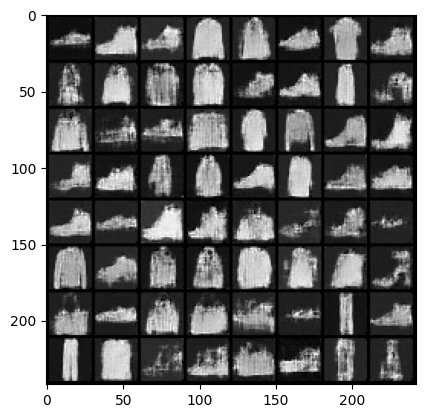

In [ ]:
print("check generation:")
list_gen_imgs = sampling(model, (batch_size, channels, image_size1, image_size2), T, constants_dict)
show_images(list_gen_imgs[-1])

## View of the diffusion process

In [ ]:
def make_gif(frame_list):
    to_pil = ToPILImage()
    frames = [to_pil(make_grid(normalize_im(tens_im))) for tens_im in frame_list]
    frame_one = frames[0]
    frame_one.save("sampling.gif.png", format="GIF", append_images=frames[::5], save_all=True, duration=10, loop=0)

    return IPython.display.Image(filename="./sampling.gif.png")

In [ ]:
make_gif(list_gen_imgs)

Output hidden; open in https://colab.research.google.com to view.

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>